<a href="https://colab.research.google.com/github/Boudia27/Projects/blob/main/project_4_energy_consumtion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 104.8 MB/s eta 0:00:00


---
# Slava script
---

In [ ]:
import datetime
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt

## HELSINKI ENERGY CONSUMPTION PROJECT

There is no collected database yet, however there is open API here https://helsinki-openapi.nuuka.cloud/swagger/index.html

- list of properties: https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/List
- api request example: https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Daily/ListByProperty?Record=LocationName&SearchString=1000%20Hakaniemen%20kauppahalli&ReportingGroup=Electricity&StartTime=2019-01-01&EndTime=2019-12-31

## Before going further - estimation of rows and dataset size
**max rows getting with 1 request is 10,000.**
- So, estimation, is it possible to get the 1 year hourly data of 1 place by 1 query:
- 366 days * 24 hours = 8,784 hours (rows); 8,800 < 10,000 it's okay
---
- Estimation of max rows for hourly data per year with all places:
- 842 places * 8,784 hours = 7,396,128 rows
- rough size approximation: 7,400,000 rows * 80 symbols =~ 600M it looks okay


---
# EXTRACTION OF DATA
---

In [ ]:
class DownloadDataEnergyHelsinki:
    '''List of parameters available:
        date_begin & date_end: string 'yyyy-mm-dd'
        period: 'Hourly' or 'Daily' or 'Monthly'
        '''

    def __init__(self, date_begin='2019-01-01', date_end='2019-12-31', period='Daily', location_list=[]):
        self.date_begin = date_begin
        self.date_end = date_end
        self.period = period
        self.location_list = location_list
        self.errors={}

    def __str__(self):
        return 'Date begin: {}\nDate end: {}\nPeriod: {}\nList of locations is {}\nDict of errors is {}'.format(
                self.date_begin, self.date_end, self.period,
                'full' if self.location_list else 'empty',
                'full' if self.errors else 'empty'
                )

    def get_property_list_from_website(self, save_csv=False):
        r = requests.get('https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/List')
        if r.status_code == 200:
            property_df = pd.DataFrame.from_dict(r.json())
            self.location_list = property_df[property_df['propertyName'].isna() == False]['locationName'].apply(lambda x: x.strip().replace(' ', '%20')).to_list()
            print('Getting property list: success')
            if save_csv:
                property_df.to_csv('property_list.csv')
                print('Save property dataset to property_list.csv: success')
        else:
            print('Getting location list: failed')

    def get_property_list_from_csv(self, file_name='property_list.csv'):
        property_df = pd.read_csv(file_name)
        self.location_list = property_df[property_df['propertyName'].isna() == False]['locationName'].apply(lambda x: x.strip().replace(' ', '%20')).to_list()
        print('Getting property list: success')

    def get_data_and_save_csv(self, custom_file_name='', num_of_loc=0, rewrite=True, from_error=False):
        if not self.location_list:
            print("File haven't been written: check list of locations (try get_location_list())")
            return

        num_of_loc = len(self.location_list) if num_of_loc == 0 else num_of_loc
        file_name = self.date_begin + ' ' + self.date_end + ' ' + self.period + '.csv' if custom_file_name == '' else custom_file_name + '.csv'

        errors = {}
        row_counter = 0

        if from_error:
            rewrite = False
            location_list = list(self.errors.keys())
            num_of_loc = len(location_list)
        else:
            location_list = self.location_list

        if rewrite:
            pd.DataFrame(columns=['timestamp', 'locationName', 'value', 'unit']).to_csv(file_name, index=False)

        print('Processing of {} places:'.format(num_of_loc))

        for i in range(num_of_loc):
            site = f'https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/{self.period}/ListByProperty?Record=LocationName&SearchString={location_list[i]}&ReportingGroup=Electricity&StartTime={self.date_begin}&EndTime={self.date_end}'
            try:
                r = requests.get(site)
                if len(r.json()) == 2:
                    errors[property_list[i]] = r.json()['errorNote']
                    print('.', end='')
                else:
                    sample = pd.DataFrame.from_dict(r.json())[['timestamp', 'locationName', 'value', 'unit']]
                    sample.to_csv(file_name, mode='a', header=False, index=False)
                    row_counter += len(r.json())
                    print('*', end='')

            except:
                print('?', end='')
                errors[property_list[i]] = 'Unknown'

            print(end='' if (i+1)%10 else '|')
            print(end='' if (i+1)%100 else '\n')

        print('Done, {} rows has been written\n{} properties are missing'.format(row_counter, len(errors)))

        self.errors = errors
        errors_ls = [{'property':key, 'error':errors[key]} for key in errors.keys()]
        pd.DataFrame.from_dict(errors_ls).to_csv('Errors ' + file_name, index=False)

    def retry_errors(self):
        self.get_data_and_save_csv(from_error=True)

downloader = DownloadDataEnergyHelsinki(date_begin="2020-01-01", date_end="2020-12-31", period='Hourly');
print(downloader)

-->
- Date begin: 2020-01-01
- Date end: 2020-12-31
- Period: Hourly
- List of locations is empty
- Dict of errors is empty

downloader.get_property_list_from_website()
-->
- Getting property list: success

downloader.get_data_and_save_csv()
-->
- Processing of 842 places:
- 5101588 rows has been written
- 253 places missing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset_Helsinki_Energy/2020-01-01 2020-12-31 Hourly.csv')
df.head()

,timestamp,locationName,value,unit
0,2020-01-01T00:00:00,1000 Hakaniemen kauppahalli,0.06,kWh
1,2020-01-01T01:00:00,1000 Hakaniemen kauppahalli,0.06,kWh
2,2020-01-01T02:00:00,1000 Hakaniemen kauppahalli,0.06,kWh
3,2020-01-01T03:00:00,1000 Hakaniemen kauppahalli,0.07,kWh
4,2020-01-01T04:00:00,1000 Hakaniemen kauppahalli,0.06,kWh


In [ ]:
# To work with months, weekdays and hours simplier

df['timestamp'] = pd.to_datetime(df['timestamp'])

df['hour'] = df['timestamp'].apply(lambda x: x.hour)

df['week_day'] = df['timestamp'].dt.dayofweek

df['month'] = df['timestamp'].dt.month

df.head()

In [ ]:
df['value'].describe().round(2)

count    5101588.00
mean          36.71
std           91.77
min            0.00
25%            4.98
50%           14.00
75%           35.39
max        92546.50
Name: value, dtype: float64

<Axes: ylabel='Frequency'>

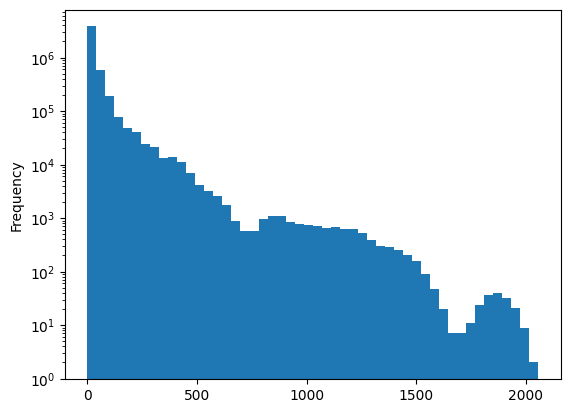

In [ ]:
# (After trimming irrelevant)

df['value'].plot.hist(bins=50, log=True)

In [ ]:
df.isna().sum()

timestamp       0
locationName    0
value           0
unit            0
hour            0
week_day        0
month           0
dtype: int64

In [ ]:
df.corr(numeric_only=True)

,value,hour,week_day,month
value,1.000000,0.007510,-0.039831,-0.003232
hour,0.007510,1.000000,0.000262,-0.000717
week_day,-0.039831,0.000262,1.000000,-0.006567
month,-0.003232,-0.000717,-0.006567,1.000000


In [ ]:
df['locationName'].value_counts()

4661 Kalasataman TeHyKe                             78442
3505 Meritalo/Lpk Haukka/lp Haukka                  51250
1000 Hakaniemen kauppahalli                          8760
4186 Lpk Pentinkulma, Lp Linnunrata                  8760
4123 Lpk Oulunkylä                                   8760
                                                    ...  
4316 Vesalan ala-aste (disabled)                     1248
4514 Lpk Savotta                                      985
4144 Lpk Kukkaniitty (disabled)                       816
6475 Toinen linja 7, toimistorakennus (disabled)      672
4445 Lpk Kotitorppa (disabloitu)                      168
Name: locationName, Length: 582, dtype: int64

___
### For my purpose I would drop all the locations with partical or overwhelmed data. 24*365=8760

---

In [ ]:
df_by_locations = df['locationName'].value_counts()
df_by_locations[df_by_locations.between(8750, 8760)]

# 557 items filtered out of 582, it is quite enough

list_of_locations = list(df_by_locations[df_by_locations.between(8750, 8760)].to_dict().keys())

df = df[df['locationName'].isin(list_of_locations)]

df

,timestamp,locationName,value,unit,hour,week_day,month
0,2020-01-01 00:00:00,1000 Hakaniemen kauppahalli,0.06,kWh,0,2,1
1,2020-01-01 01:00:00,1000 Hakaniemen kauppahalli,0.06,kWh,1,2,1
2,2020-01-01 02:00:00,1000 Hakaniemen kauppahalli,0.06,kWh,2,2,1
3,2020-01-01 03:00:00,1000 Hakaniemen kauppahalli,0.07,kWh,3,2,1
4,2020-01-01 04:00:00,1000 Hakaniemen kauppahalli,0.06,kWh,4,2,1
...,...,...,...,...,...,...,...
5092917,2020-12-30 20:00:00,4763 Jätkäsaaren liikuntapuiston huoltorakennus,648.96,kWh,20,2,12
5092918,2020-12-30 21:00:00,4763 Jätkäsaaren liikuntapuiston huoltorakennus,581.64,kWh,21,2,12
5092919,2020-12-30 22:00:00,4763 Jätkäsaaren liikuntapuiston huoltorakennus,503.15,kWh,22,2,12
5092920,2020-12-30 23:00:00,4763 Jätkäsaaren liikuntapuiston huoltorakennus,454.80,kWh,23,2,12


<Axes: xlabel='month'>

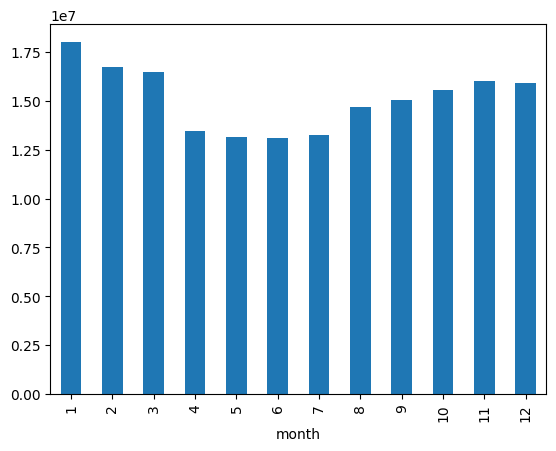

In [ ]:
# Distribution sum kW by month

df.groupby('month')['value'].sum().plot.bar()

<Axes: xlabel='week_day'>

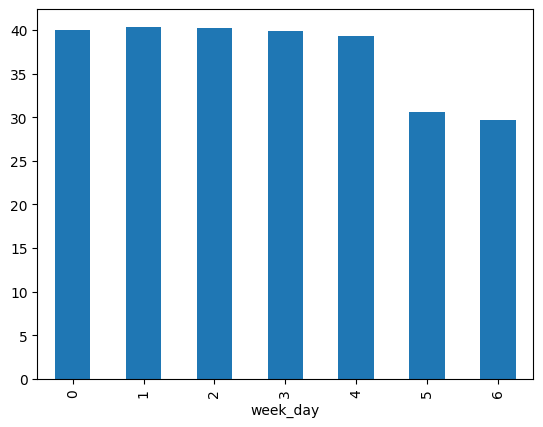

In [ ]:
# Distribution mean kW by week day

df.groupby('week_day')['value'].mean().plot.bar()

<Axes: xlabel='hour'>

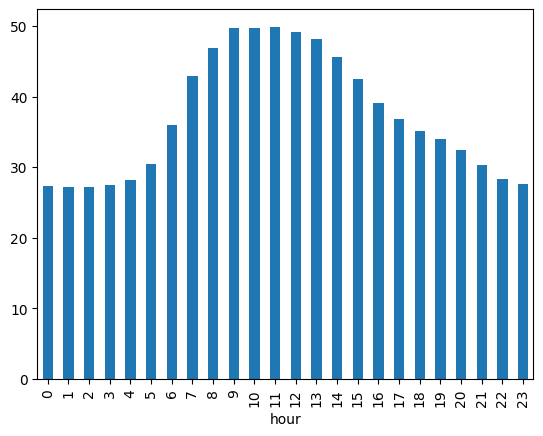

In [ ]:
# Distribution mean kW by hour

df.groupby('hour')['value'].mean().plot.bar()

In [ ]:
# mean kW by hour by location (top 20)

df.groupby('locationName')['value'].mean().sort_values(ascending=False).head(20)

locationName
2247 Tukkutori                                           1033.109379
4328 HYKS Psykiatriakeskus                                546.232359
2252 K 6 makasiini (disabled)                             491.583018
4370 Malmin päivystyssairaala, Malmin nuorisotalo         485.654960
4192 Laakson sairaala                                     455.811061
4229 Auroran sairaala ja koulu                            355.056970
4160 Koskelan monipuolinen palvelukeskus                  346.096416
4240 Kustaankartano                                       332.603722
1862 Kallion virastotalo                                  323.211885
3504 Helsingin Tennispalatsi Koy                          270.130099
4273 Stadin am.op/Prinsessantie 2                         262.600897
1761 K30, Leijonakortteli                                 257.834616
4003 Keskuspelastusasema                                  241.365421
1764 K31, Sarvikuono kortteli                             239.883697
4238 Itäkeskuksen uim

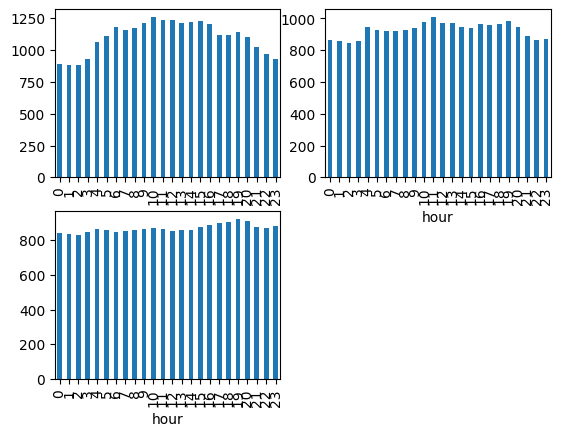

In [ ]:
# look at some market in different week days (Th, Sa, Su):

plt.subplot(221)
df[(df['locationName'] == '2247 Tukkutori') & (df['week_day'] ==3)].groupby('hour')['value'].mean().plot.bar()

plt.subplot(222)
df[(df['locationName'] == '2247 Tukkutori') & (df['week_day'] == 5)].groupby('hour')['value'].mean().plot.bar()

plt.subplot(223)
df[(df['locationName'] == '2247 Tukkutori') & (df['week_day'] == 6)].groupby('hour')['value'].mean().plot.bar()

plt.show()

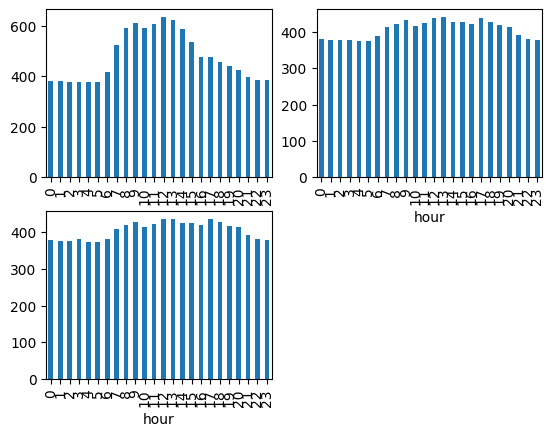

In [ ]:
# look at some hospital in different week days (Th, Sa, Su):

plt.subplot(221)
df[(df['locationName'] == '4192 Laakson sairaala') & (df['week_day'] ==3)].groupby('hour')['value'].mean().plot.bar()

plt.subplot(222)
df[(df['locationName'] == '4192 Laakson sairaala') & (df['week_day'] == 5)].groupby('hour')['value'].mean().plot.bar()

plt.subplot(223)
df[(df['locationName'] == '4192 Laakson sairaala') & (df['week_day'] == 6)].groupby('hour')['value'].mean().plot.bar()

plt.show()

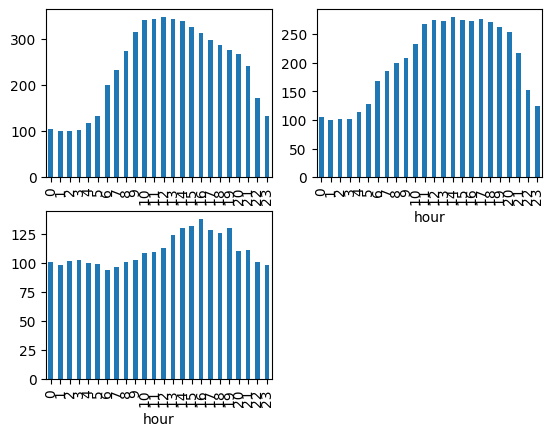

In [ ]:
# look at some theater in different week days (Th, Sa, Su):

plt.subplot(221)
df[(df['locationName'] == '4479 Kaupunginteatteri') & (df['week_day'] ==3)].groupby('hour')['value'].mean().plot.bar()

plt.subplot(222)
df[(df['locationName'] == '4479 Kaupunginteatteri') & (df['week_day'] == 5)].groupby('hour')['value'].mean().plot.bar()

plt.subplot(223)
df[(df['locationName'] == '4479 Kaupunginteatteri') & (df['week_day'] == 6)].groupby('hour')['value'].mean().plot.bar()

plt.show()

---
I could try classify the places which is working at holidays and which is not by ratio of max and min in Sunday

---

<Axes: ylabel='Frequency'>

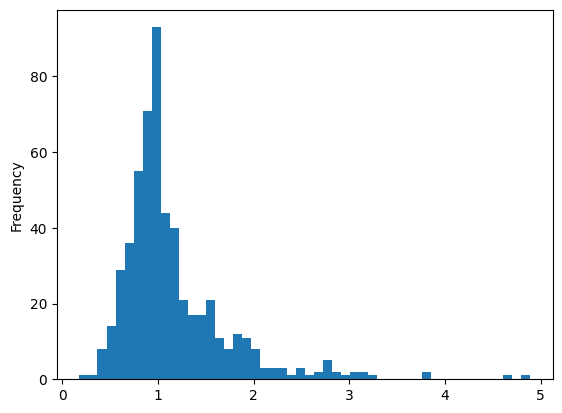

In [ ]:
# Distribution of Sunday ratio (between 12 and 01 o'clock)

df_sunday_12 = df[(df['week_day'] == 6) & (df['hour'] == 13)].groupby('locationName')['value'].mean()
df_sunday_1 = df[(df['week_day'] == 6) & (df['hour'] == 1)].groupby('locationName')['value'].mean()
df_sunday_ratio = df_sunday_12 / df_sunday_1
df_sunday_ratio[df_sunday_ratio < 5].plot.hist(bins=50)

<Axes: ylabel='Frequency'>

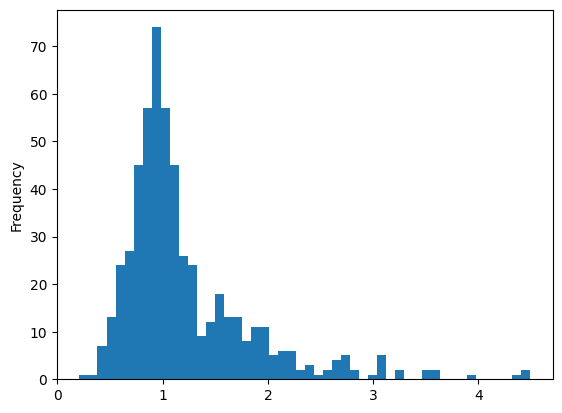

In [ ]:
# Distribution of Saturday ratio (between 12 and 01 o'clock)

df_sunday_12 = df[(df['week_day'] == 5) & (df['hour'] == 13)].groupby('locationName')['value'].mean()
df_sunday_1 = df[(df['week_day'] == 5) & (df['hour'] == 1)].groupby('locationName')['value'].mean()
df_saturday_ratio = df_sunday_12 / df_sunday_1
df_saturday_ratio[df_saturday_ratio < 5].plot.hist(bins=50)

<Axes: ylabel='Frequency'>

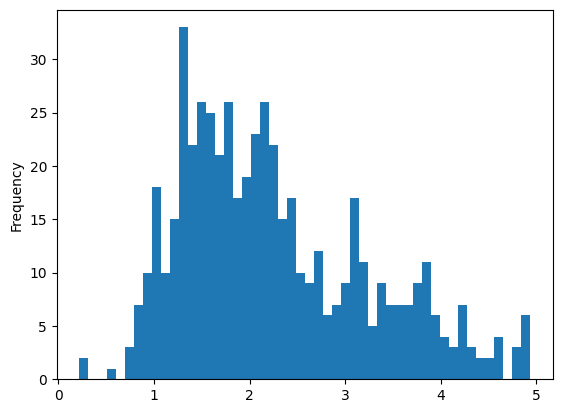

In [ ]:
# Distribution of Wednesday ratio (between 12 and 01 o'clock)

df_wed_12 = df[(df['week_day'] == 2) & (df['hour'] == 13)].groupby('locationName')['value'].mean()
df_wed_1 = df[(df['week_day'] == 2) & (df['hour'] == 3)].groupby('locationName')['value'].mean()
df_wednesday_ratio = df_wed_12 / df_wed_1
df_wednesday_ratio[df_wednesday_ratio < 5].plot.hist(bins=50)

In [ ]:
df_wednesday_ratio.describe()

count    553.000000
mean       2.554438
std        4.065778
min        0.219498
25%        1.511405
50%        2.094869
75%        3.064834
max       93.539216
Name: value, dtype: float64

---
- Majority of places doesn't work at holidays
- Typical ratios are in range 1.5-3
---

___
### 2) Dependance on air temperature
---

In [ ]:
# Processing Temperature Data. It has distinct datetime attributes and wrong UTC

df_tmp = pd.read_csv('/content/drive/MyDrive/Dataset_Helsinki_Energy/temperature_helsinki_2020.csv')
df_tmp['datetime'] = pd.to_datetime(df_tmp['Year'].astype(str)+'-'+df_tmp['m'].astype(str)+'-'+df_tmp['d'].astype(str)+'-'+df_tmp['Time'].astype(str))

df_tmp.head()

,Year,m,d,Time,Time zone,Air temperature (degC),datetime
0,2019,12,31,00:00,UTC,4.1,2019-12-31 00:00:00
1,2019,12,31,01:00,UTC,3.8,2019-12-31 01:00:00
2,2019,12,31,02:00,UTC,3.4,2019-12-31 02:00:00
3,2019,12,31,03:00,UTC,3.3,2019-12-31 03:00:00
4,2019,12,31,04:00,UTC,3,2019-12-31 04:00:00


In [ ]:
df_tmp['datetime'] = df_tmp['datetime'] + pd.DateOffset(hours=3)

df_tmp = df_tmp[['Air temperature (degC)', 'datetime']]

# Writing db to the file

df_tmp[df_tmp['datetime'].dt.year == 2020].to_csv('air_temp_helsinki_adapted.csv')

# Writing db to the DataFrame

df_tmp = df_tmp[df_tmp['datetime'].dt.year == 2020]

# resetting index, numericing temperature column

df_tmp = df_tmp.reset_index()
df_tmp['Air temperature (degC)'] = pd.to_numeric(df_tmp['Air temperature (degC)'], errors='coerce')
df_tmp.fillna(0)

,index,Air temperature (degC),datetime
0,21,-2.1,2020-01-01 00:00:00
1,22,-2.0,2020-01-01 01:00:00
2,23,-1.4,2020-01-01 02:00:00
3,24,-1.9,2020-01-01 03:00:00
4,25,-2.1,2020-01-01 04:00:00
...,...,...,...
8779,8800,0.8,2020-12-31 19:00:00
8780,8801,0.7,2020-12-31 20:00:00
8781,8802,0.5,2020-12-31 21:00:00
8782,8803,0.2,2020-12-31 22:00:00


In [ ]:
# synchronization of datetime column

df_tmp = df_tmp[df_tmp['datetime'] < '2020-12-31 00:00:00']

In [ ]:
len(df.groupby('timestamp')), len(df_tmp)

(8760, 8760)

---
### Now plotting:
---

<Axes: xlabel='temperature', ylabel='value'>

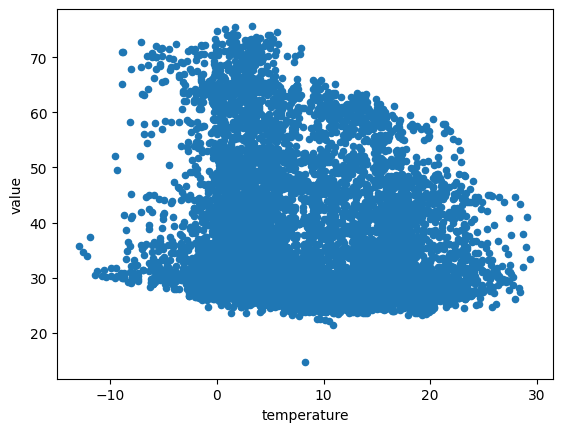

In [ ]:
means_by_hour = df.groupby('timestamp')['value'].mean().to_list()
temp_by_hour = df_tmp['Air temperature (degC)'].to_list()

df_means_temp = pd.DataFrame({'value':means_by_hour, 'temperature':temp_by_hour})

# mean values by temperature, all the values

df_means_temp.plot.scatter('temperature', 'value')

Too noisy, however it looks like it's a few trends, lowest and a few higher. I'll try to divide them

<Axes: xlabel='temperature', ylabel='value'>

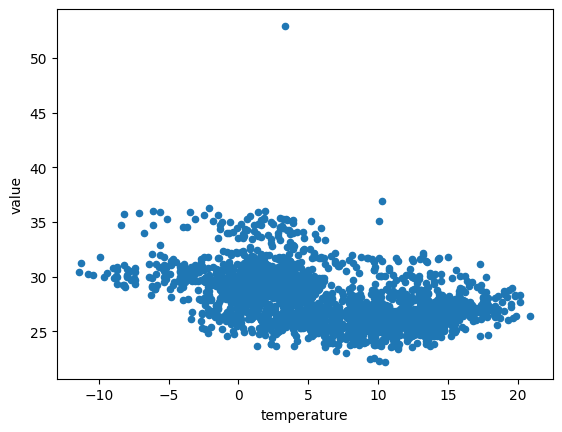

In [ ]:
# # mean values by temperature, from 00:00 to 06:00 (when everything is 100% closed)

means_by_hour_0_5 = df[df['timestamp'].dt.hour.between(0, 5)].groupby('timestamp')['value'].mean().to_list()
temp_by_hour_0_5 = df_tmp[df_tmp['datetime'].dt.hour.between(0, 5)]['Air temperature (degC)'].to_list()

df_means_temp_0_5 = pd.DataFrame({'value':means_by_hour_0_5, 'temperature':temp_by_hour_0_5})
df_means_temp_0_5.plot.scatter('temperature', 'value')

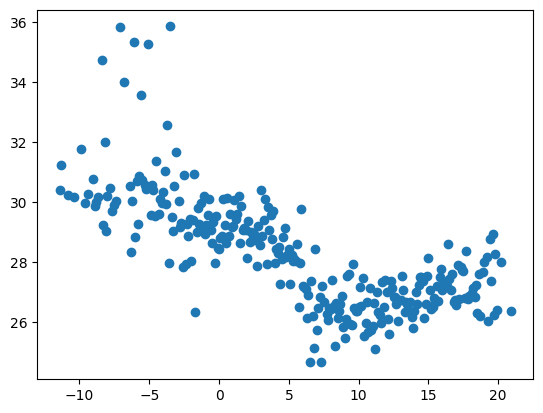

In [ ]:
# The same, but for every temperature mean of mean values was calculated

plt.scatter(df_means_temp_0_5.groupby('temperature')['value'].mean().to_dict().keys(),
           df_means_temp_0_5.groupby('temperature')['value'].mean().to_dict().values())

**- It looks it has 2 trends and the most optimal point is around +10**

<Axes: xlabel='temperature', ylabel='value'>

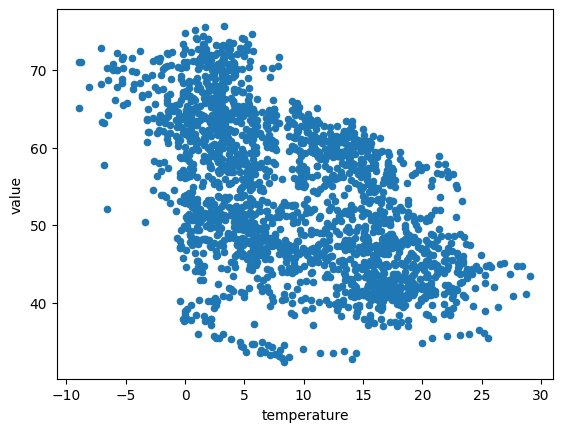

In [ ]:
# mean values by temperature, from 8 to 16 pm Mo-Fr (typical business hours)

means_by_hour_8_15 = df[(df['timestamp'].dt.hour.between(8, 15) & (df['week_day'] <= 4))].groupby('timestamp')['value'].mean().to_list()
temp_by_hour_8_15 = df_tmp[(df_tmp['datetime'].dt.hour.between(8, 15)) & (df_tmp['datetime'].dt.dayofweek <= 4)]['Air temperature (degC)'].to_list()

df_means_temp_8_15 = pd.DataFrame({'value':means_by_hour_8_15, 'temperature':temp_by_hour_8_15})
df_means_temp_8_15.plot.scatter('temperature', 'value')

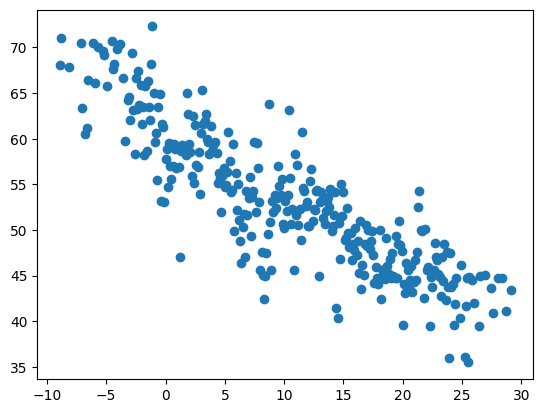

In [ ]:
# The same, but for every temperature mean of mean values was calculated

plt.scatter(df_means_temp_8_15.groupby('temperature')['value'].mean().to_dict().keys(),
           df_means_temp_8_15.groupby('temperature')['value'].mean().to_dict().values())

- looks like a linear trend down, approximately y = -3/4x + 60

#### doing the same with rounded temperature (to reduce noise)

In [ ]:
# doing the same with rounded temperature (to reduce noise)

df_tmp['temp_rounded'] = df_tmp['Air temperature (degC)'].round(0)
df_tmp.head()

,index,Air temperature (degC),datetime,temp_rounded
0,21,-2.1,2020-01-01 00:00:00,-2.0
1,22,-2.0,2020-01-01 01:00:00,-2.0
2,23,-1.4,2020-01-01 02:00:00,-1.0
3,24,-1.9,2020-01-01 03:00:00,-2.0
4,25,-2.1,2020-01-01 04:00:00,-2.0


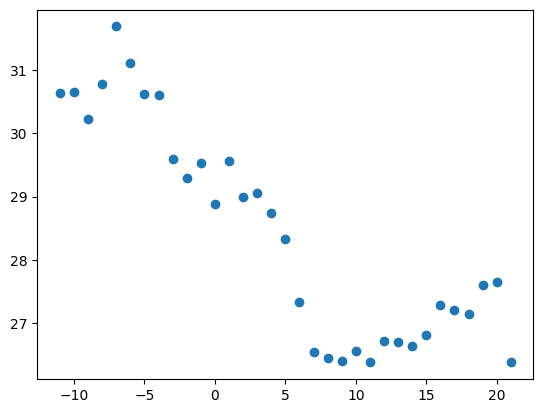

In [ ]:
means_by_hour_0_5 = df[df['timestamp'].dt.hour.between(0, 5)].groupby('timestamp')['value'].mean().to_list()
temp_by_hour_0_5 = df_tmp[df_tmp['datetime'].dt.hour.between(0, 5)]['temp_rounded'].to_list()

# mean of mean values by rounded temperature at night (0 - 6 am)

df_means_temp_0_5 = pd.DataFrame({'value':means_by_hour_0_5, 'temperature':temp_by_hour_0_5})

plt.scatter(df_means_temp_0_5.groupby('temperature')['value'].mean().to_dict().keys(),
           df_means_temp_0_5.groupby('temperature')['value'].mean().to_dict().values())

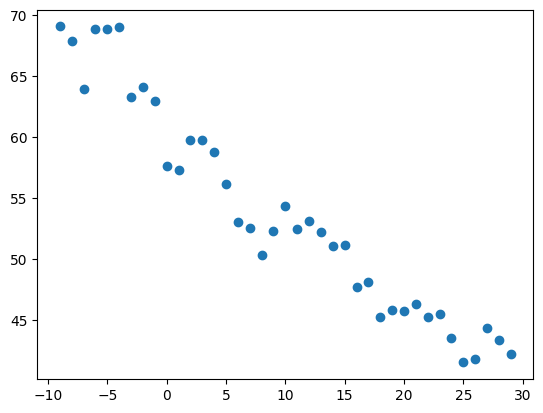

In [ ]:
# mean of mean values by rounded temperature, from 8 to 16 Mo-Fr (typical business hours)

means_by_hour_8_15 = df[(df['timestamp'].dt.hour.between(8, 15) & (df['week_day'] <= 4))].groupby('timestamp')['value'].mean().to_list()
temp_by_hour_8_15 = df_tmp[(df_tmp['datetime'].dt.hour.between(8, 15)) & (df_tmp['datetime'].dt.dayofweek <= 4)]['temp_rounded'].to_list()

df_means_temp_8_15 = pd.DataFrame({'value':means_by_hour_8_15, 'temperature':temp_by_hour_8_15})

plt.scatter(df_means_temp_8_15.groupby('temperature')['value'].mean().to_dict().keys(),
           df_means_temp_8_15.groupby('temperature')['value'].mean().to_dict().values())

## Observations:
It must be a relationship between air temperature and energy consumption:
- It's not a big range in time of idling (approx -1,5 kW mean for each +5C until +10C and then +1 kW for each +5C)
- It's a big range while business hours and a clear linear dependence between temperature and mean energy consumption.

---
THE END OF SLAVA'S PART

---

# Ahmed Script

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import re
import folium
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
import folium
import geopandas as gpd
import pandas as pd
import scipy.stats as stats


In [ ]:
# Read the CSV file
df_2019 = pd.read_csv('/content/drive/MyDrive/Projects/project_4_energy_consumtion/dataset_2019.csv')
df_daily = pd.read_csv('/content/drive/MyDrive/Projects/project_4_energy_consumtion/dataset_daily.csv')

# Display the data
print("Dataset 2019:")
print(df_2019.head())

print("Dataset Daily:")
print(df_daily.head())


Dataset 2019:
             timestamp                 locationName  value unit
0  2019-01-08T00:00:00  1000 Hakaniemen kauppahalli    0.0  kWh
1  2019-01-08T01:00:00  1000 Hakaniemen kauppahalli    0.0  kWh
2  2019-01-08T02:00:00  1000 Hakaniemen kauppahalli    0.0  kWh
3  2019-01-08T03:00:00  1000 Hakaniemen kauppahalli    0.0  kWh
4  2019-01-08T04:00:00  1000 Hakaniemen kauppahalli    0.0  kWh
Dataset Daily:
             timestamp                 locationName    value unit
0  2016-01-01T00:00:00  1000 Hakaniemen kauppahalli  3189.46  kWh
1  2016-01-02T00:00:00  1000 Hakaniemen kauppahalli  3729.02  kWh
2  2016-01-03T00:00:00  1000 Hakaniemen kauppahalli  3151.78  kWh
3  2016-01-04T00:00:00  1000 Hakaniemen kauppahalli  3699.97  kWh
4  2016-01-05T00:00:00  1000 Hakaniemen kauppahalli  3710.28  kWh


In [ ]:
# Print the columns of each dataset
print("Columns in dataset 2019:")
print(df_2019.columns)

print("Columns in dataset Daily:")
print(df_daily.columns)

Columns in dataset 2019:
Index(['timestamp', 'locationName', 'value', 'unit'], dtype='object')
Columns in dataset Daily:
Index(['timestamp', 'locationName', 'value', 'unit'], dtype='object')


In [ ]:
# Get unique location names
location_names = df_2019['locationName'].unique().tolist()

# Print the list of location names
print("List of Location Names:")
for location in location_names:
    print(location)
# Create a DataFrame with the location names
df_locations = pd.DataFrame({'LocationName': location_names})

# Save the DataFrame as a CSV file

df_locations.to_csv('/content/drive/MyDrive/Projects/project_4_energy_consumtion/location_names.csv', index=False)

List of Location Names:
1000 Hakaniemen kauppahalli
1001 Hietalahden kauppahalli
1002 Vanha kauppahalli
1037 Vuotalo
1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen
1508 Monitoimitalo Puustelli
1509 Lpk Karvikka ja rppk Lemmikki
1511 Pauligin huvila
1512 Malmin raitti 3
1513 Psykiatrinen poliklinikka
1515 Myllypuron peruskoulu/Lpk Neulanen/Neulapadont. 6
1521 Harjun NT (disabled)
1526 Annantalo
1527 Koskelan NT
1528 Apollon yhteiskoulu
1540 Virastotalo, Dagmarinkatu 6 (disabled)
1544 Lpk Linnunlaulu ja Lpk Arla
1546 Koulutuskeskus
1550 Fallkullan kartano/Kotieläintila
1556 Harakan luontokeskus
1561 Työterveyskeskus
1575 Nuorisoasiainkeskus, Lpk Leppäsuo
1580 Kruununmakasiini
1591 Etelä-Haagan kirjasto, NT
1598 Jakomäen kirjasto
1603 Korttelitalo Merirasti
1608 Koskelan ala-aste /Lpk Herttua
1610 Laakavuoren korttelitalo/a-a/Lpk
1620 Tulli- ja pakkahuone, K 11
1621 Ravintola Kappeli ja lava
1627 Kurkimäen korttelitalo, Lpk ja Lp
1630 K 4, Elefanttikortteli
1637 Lp Kesanto
1644 Ty

# Energy Consumption Trends
to identify patterns and trends in energy consumption. This could involve calculating daily, monthly, or yearly averages, finding peak consumption periods, or comparing energy consumption across different locations ('locationName').

In [ ]:
# Convert 'timestamp' column to datetime type
df_2019['timestamp'] = pd.to_datetime(df_2019['timestamp'])
df_daily['timestamp'] = pd.to_datetime(df_daily['timestamp'])

# Calculate monthly averages
monthly_averages_2019 = df_2019.groupby(df_2019['timestamp'].dt.month)['value'].mean()
monthly_averages_daily = df_daily.groupby(df_daily['timestamp'].dt.month)['value'].mean()

# Find peak consumption periods
peak_periods_2019 = df_2019.groupby(df_2019['timestamp'].dt.month)['value'].max()
peak_periods_daily = df_daily.groupby(df_daily['timestamp'].dt.month)['value'].max()

# Compare energy consumption across different locations
location_comparison_2019 = df_2019.groupby('locationName')['value'].sum()
location_comparison_daily = df_daily.groupby('locationName')['value'].sum()

# Print the results
print("Monthly Averages in 2019:")
print(monthly_averages_2019)

print("Monthly Averages in Daily Dataset:")
print(monthly_averages_daily)

print("Peak Consumption Periods in 2019:")
print(peak_periods_2019)

print("Peak Consumption Periods in Daily Dataset:")
print(peak_periods_daily)

print("Energy Consumption Comparison by Location in 2019:")
print(location_comparison_2019)

print("Energy Consumption Comparison by Location in Daily Dataset:")
print(location_comparison_daily)


Monthly Averages in 2019:
timestamp
1     41.844840
2     41.891763
3     40.896037
4     37.855590
5     36.787104
6     32.601375
7     30.759098
8     35.793295
9     38.696929
10    40.764455
11    42.879994
12    40.750505
Name: value, dtype: float64
Monthly Averages in Daily Dataset:
timestamp
1     1005.796454
2     1009.384698
3      976.119654
4      887.891206
5      834.854828
6      783.851831
7      734.550429
8      851.106912
9      898.285428
10     936.184050
11    1011.681023
12     990.907053
Name: value, dtype: float64
Peak Consumption Periods in 2019:
timestamp
1     2642.00
2     2090.98
3     2077.58
4     2086.44
5     2093.75
6     2011.69
7     1764.34
8     2025.02
9     4596.25
10    2074.28
11    2034.68
12    8309.75
Name: value, dtype: float64
Peak Consumption Periods in Daily Dataset:
timestamp
1     146316.500
2      34271.060
3      33673.080
4     124774.940
5      30905.130
6     282966.000
7     121460.875
8      35463.010
9     129118.500
10    206

# Location-based Analysis
Explore how energy consumption varies across different locations. You can group the data by 'locationName' and analyze the energy consumption patterns, compare consumption levels between locations, or identify any outliers or anomalies.

In [ ]:
# Group the data by 'locationName' and calculate energy consumption statistics
location_analysis_2019 = df_2019.groupby('locationName')['value'].agg(['sum', 'mean', 'min', 'max'])
location_analysis_daily = df_daily.groupby('locationName')['value'].agg(['sum', 'mean', 'min', 'max'])

# Print the location-based analysis results
print("Location-based Analysis for 2019 Dataset:")
print(location_analysis_2019)

print("Location-based Analysis for Daily Dataset:")
print(location_analysis_daily)

Location-based Analysis for 2019 Dataset:
                                                           sum        mean  \
locationName                                                                 
1000 Hakaniemen kauppahalli                           13232.93    1.544460   
1001 Hietalahden kauppahalli                         371539.22   43.007202   
1002 Vanha kauppahalli                               141401.30   16.365891   
1037 Vuotalo                                         930202.18  107.662289   
1507 Suutarilan monitoimitalo/ala-aste ja Lpk S...   710130.28   82.191005   
...                                                        ...         ...   
6477 Muotoilijankatu 3, Stadin ammattiopisto         706681.20   81.801273   
6478 Savonkatu 4, Stadin ammattiopisto               623230.08   72.133111   
6492 Kontukuja 5, Kontulan monipuolinen palvelu...  2079493.68  240.709999   
6743 Kivikonkuja 4, terveydenhuollon päätearkisto    302700.24   35.038805   
6760 Kaupunkiympäristö

# Unit Conversion and Standardization
Check the 'unit' column to ensure that the energy consumption values are in a consistent unit. If not, you may need to convert the values to a standardized unit for accurate analysis and comparison.

In [ ]:
# Check unique units in the 'unit' column
unique_units_2019 = df_2019['unit'].unique()
unique_units_daily = df_daily['unit'].unique()

# Convert energy consumption to a standardized unit if necessary
if len(unique_units_2019) > 1:
    # Convert values in the 2019 dataset to a standardized unit
    conversion_factor_2019 = 1.0  # Modify this based on the conversion needed
    df_2019['value'] = df_2019['value'] * conversion_factor_2019

if len(unique_units_daily) > 1:
    # Convert values in the daily dataset to a standardized unit
    conversion_factor_daily = 1.0  # Modify this based on the conversion needed
    df_daily['value'] = df_daily['value'] * conversion_factor_daily

# Perform analysis and comparison with standardized units
# Example: Calculate monthly averages with standardized units
monthly_averages_2019 = df_2019.groupby(df_2019['timestamp'].dt.month)['value'].mean()
monthly_averages_daily = df_daily.groupby(df_daily['timestamp'].dt.month)['value'].mean()

# Print the results
print("Monthly Averages in 2019 (Standardized Unit):")
print(monthly_averages_2019)

print("Monthly Averages in Daily Dataset (Standardized Unit):")
print(monthly_averages_daily)

Monthly Averages in 2019 (Standardized Unit):
timestamp
1     41.844840
2     41.891763
3     40.896037
4     37.855590
5     36.787104
6     32.601375
7     30.759098
8     35.793295
9     38.696929
10    40.764455
11    42.879994
12    40.750505
Name: value, dtype: float64
Monthly Averages in Daily Dataset (Standardized Unit):
timestamp
1     1005.796454
2     1009.384698
3      976.119654
4      887.891206
5      834.854828
6      783.851831
7      734.550429
8      851.106912
9      898.285428
10     936.184050
11    1011.681023
12     990.907053
Name: value, dtype: float64


Plot

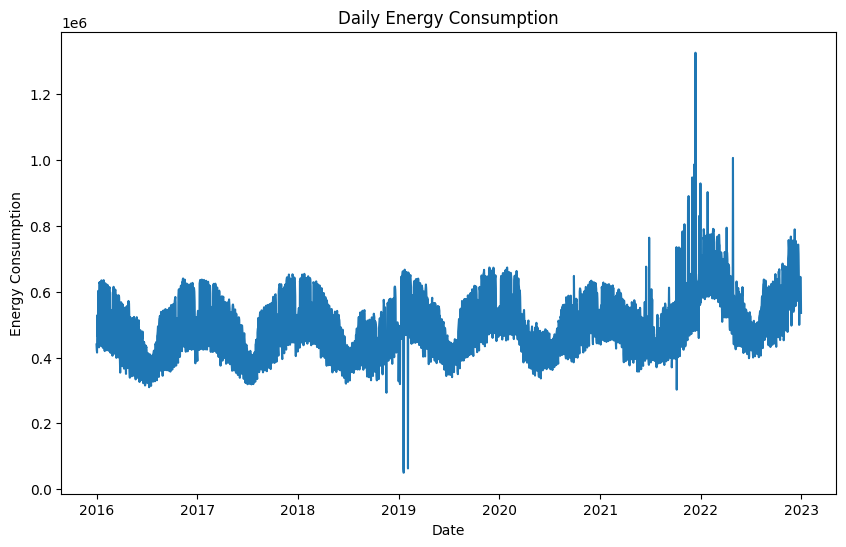

In [ ]:
# Check unique units in the 'unit' column
unique_units_2019 = df_2019['unit'].unique()
unique_units_daily = df_daily['unit'].unique()

# Convert energy consumption to a standardized unit if necessary
if len(unique_units_2019) > 1:
    # Convert values in the 2019 dataset to a standardized unit
    conversion_factor_2019 = 1.0  # Modify this based on the conversion needed
    df_2019['value'] = df_2019['value'] * conversion_factor_2019

if len(unique_units_daily) > 1:
    # Convert values in the daily dataset to a standardized unit
    conversion_factor_daily = 1.0  # Modify this based on the conversion needed
    df_daily['value'] = df_daily['value'] * conversion_factor_daily


# Daily Consumption Plot
daily_consumption = df_daily.groupby(df_daily['timestamp'].dt.date)['value'].sum()

plt.figure(figsize=(10, 6))
plt.plot(daily_consumption.index, daily_consumption.values)
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Daily Energy Consumption')
plt.show()

# Seasonal Analysis
Extract the month or season from the 'timestamp' column and analyze energy consumption patterns across different seasons. This could help identify any seasonal variations or trends in energy usage.

In [ ]:
# Convert 'timestamp' column to datetime type
df_2019['timestamp'] = pd.to_datetime(df_2019['timestamp'])
df_daily['timestamp'] = pd.to_datetime(df_daily['timestamp'])

# Extract the month or season from the 'timestamp' column
df_2019['month'] = df_2019['timestamp'].dt.month
df_daily['month'] = df_daily['timestamp'].dt.month

# Perform seasonal analysis
seasonal_analysis_2019 = df_2019.groupby('month')['value'].mean()
seasonal_analysis_daily = df_daily.groupby('month')['value'].mean()

# Print the results
print("Seasonal Analysis in 2019:")
print(seasonal_analysis_2019)

print("Seasonal Analysis in Daily Dataset:")
print(seasonal_analysis_daily)

Seasonal Analysis in 2019:
month
1     41.844840
2     41.891763
3     40.896037
4     37.855590
5     36.787104
6     32.601375
7     30.759098
8     35.793295
9     38.696929
10    40.764455
11    42.879994
12    40.750505
Name: value, dtype: float64
Seasonal Analysis in Daily Dataset:
month
1     1005.796454
2     1009.384698
3      976.119654
4      887.891206
5      834.854828
6      783.851831
7      734.550429
8      851.106912
9      898.285428
10     936.184050
11    1011.681023
12     990.907053
Name: value, dtype: float64


# Plot Seasonal Energy Consumption

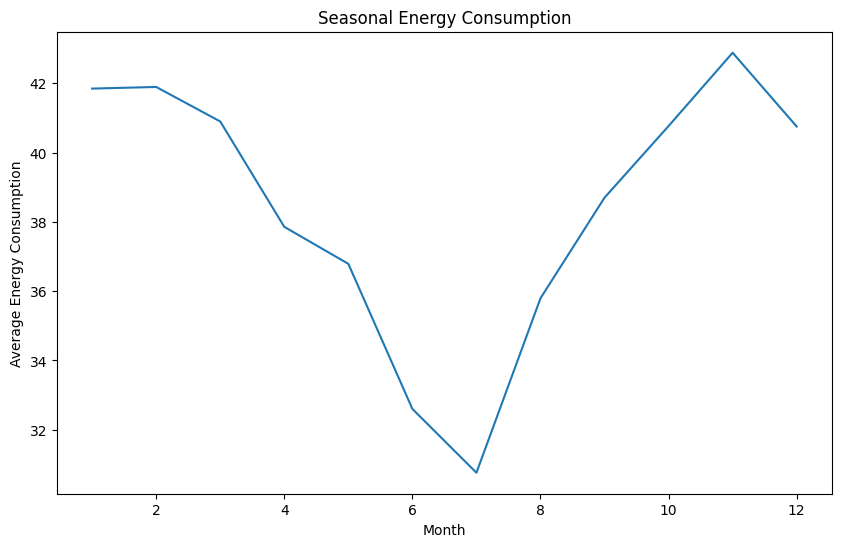

In [ ]:
# Check unique units in the 'unit' column
unique_units_2019 = df_2019['unit'].unique()
unique_units_daily = df_daily['unit'].unique()

# Convert energy consumption to a standardized unit if necessary
if len(unique_units_2019) > 1:
    # Convert values in the 2019 dataset to a standardized unit
    conversion_factor_2019 = 1.0  # Modify this based on the conversion needed
    df_2019['value'] = df_2019['value'] * conversion_factor_2019

if len(unique_units_daily) > 1:
    # Convert values in the daily dataset to a standardized unit
    conversion_factor_daily = 1.0  # Modify this based on the conversion needed
    df_daily['value'] = df_daily['value'] * conversion_factor_daily

# Extract the month from the 'timestamp' column
df_2019['month'] = df_2019['timestamp'].dt.month
df_daily['month'] = df_daily['timestamp'].dt.month

# Seasonal Consumption Plot
seasonal_consumption_2019 = df_2019.groupby('month')['value'].mean()

plt.figure(figsize=(10, 6))
plt.plot(seasonal_consumption_2019.index, seasonal_consumption_2019.values)
plt.xlabel('Month')
plt.ylabel('Average Energy Consumption')
plt.title('Seasonal Energy Consumption')
plt.show()

#Energy consumption for each location

In [ ]:

# Concatenate the two DataFrames
df = pd.concat([df_2019, df_daily])

# Get unique location names from the DataFrame
location_list = df['locationName'].unique().tolist()
new_location_list = []

grouped_data = round(df.groupby('locationName')['value'].mean(), 2)
mean_values_list = grouped_data.values.tolist()

for location in location_list:
    # Remove numeric values from the location
    cleaned_location = re.sub(r'\d', '', location).strip()

    # Add the cleaned location to the new_location_list if it's not empty
    if cleaned_location:
        new_location_list.append(cleaned_location)

# Create a map centered on Finland
map_center = [65, 26]  # Latitude and longitude coordinates for Finland
m = folium.Map(location=map_center, zoom_start=6, tiles='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png', attr='CartoDB Attribution')

# Create a MarkerCluster layer for the markers
marker_cluster = MarkerCluster().add_to(m)

# Create a geocoder object
geolocator = Nominatim(user_agent="my-app")

# Iterate over the new_location_list, retrieve their coordinates, and add markers to the map
for index, location in enumerate(new_location_list):
    # Get the corresponding location from the original location_list
    original_location = location_list[new_location_list.index(location)]

    # Get the latitude and longitude coordinates for the location
    location_data = geolocator.geocode(location)
    if location_data and location_data.raw["display_name"].endswith("Finland"):
        latitude = location_data.latitude
        longitude = location_data.longitude

        # Get the mean value from mean_values_list based on the index
        mean_value = mean_values_list[index]

        # Set marker color based on energy consumption
        if mean_value >= 500:  # Adjust the threshold as per your data
            marker_color = 'red'
        else:
            marker_color = 'blue'  # Default color

        # Create a marker for the location with popup displaying the location name and mean value
        popup_text = f"<div style='text-align:center;'><strong>Location:</strong> {original_location}<br><br><strong>Mean Energy Consumption:</strong> {mean_value} kWh</div>"
        marker = folium.Marker(location=[latitude, longitude], popup=popup_text, icon=folium.Icon(color=marker_color))
        marker.add_to(marker_cluster)

# Display the map
m


## Peak energy seasonal consumption

In [ ]:
# Convert 'timestamp' column to datetime type
df_2019['timestamp'] = pd.to_datetime(df_2019['timestamp'])
df_daily['timestamp'] = pd.to_datetime(df_daily['timestamp'])

# Check unique units in the 'unit' column
unique_units_2019 = df_2019['unit'].unique()
unique_units_daily = df_daily['unit'].unique()

# Convert energy consumption to a standardized unit if necessary
if len(unique_units_2019) > 1:
    # Convert values in the 2019 dataset to a standardized unit
    conversion_factor_2019 = 1.0  # Modify this based on the conversion needed
    df_2019['value'] = df_2019['value'] * conversion_factor_2019

if len(unique_units_daily) > 1:
    # Convert values in the daily dataset to a standardized unit
    conversion_factor_daily = 1.0  # Modify this based on the conversion needed
    df_daily['value'] = df_daily['value'] * conversion_factor_daily

# Extract the month or season from the 'timestamp' column
df_2019['season'] = df_2019['timestamp'].dt.month
df_daily['season'] = df_daily['timestamp'].dt.month

# Group by location and season, and calculate total energy consumption
location_season_consumption_2019 = df_2019.groupby(['locationName', 'season'])['value'].sum()
location_season_consumption_daily = df_daily.groupby(['locationName', 'season'])['value'].sum()

# Calculate the peak consumption periods by location
peak_periods_2019 = location_season_consumption_2019.groupby('locationName').idxmax().apply(lambda x: x[1])
peak_periods_daily = location_season_consumption_daily.groupby('locationName').idxmax().apply(lambda x: x[1])

# Sort locations based on their peak consumption periods
sorted_locations_2019 = peak_periods_2019.sort_values().index
sorted_locations_daily = peak_periods_daily.sort_values().index

# Print the locations from high to low peak consumption periods (2019 dataset)
print("Peak Consumption Periods - 2019 Dataset:")
for location in sorted_locations_2019:
    print(location)

# Print the locations from high to low peak consumption periods (daily dataset)
print("\nPeak Consumption Periods - Daily Dataset:")
for location in sorted_locations_daily:
    print(location)


Peak Consumption Periods - 2019 Dataset:
4411 Lp Iso-Antti
4201 Rppk Kimalainen (disabled)
4019 Lp Linja, Ilolan puisto
4385 Lp Trumpetti (disabled)
4034 Kangasalantie väestönsuoja
4377 Lp Tervapääsky (disabled)
4040 Vuoniityn peruskoulu/Heteniityntien toimipiste
4374 Lpk Norppa
4043 Konalan ala-aste (disabled)
4046 Lp Hilleri, 25820 leikkipuisto 
4366 Drumsö lågstadieskola
4049 Lpk Humikkala
4361 Lpk Sinivuori
4359 Lpk Floora ja paviljonki (Vaahterakylä)
4068 Toukola väestönsuoja
4348 Stadin am.op/Sturenkatu  18-20
4014 Atomitie 4-6, Stara toimipiste
4412 Lp Kannelmäki, 34966 leikkipuisto  (disabled)
4427 Lpk Pelimanni/Vetelintie 4
4428 Lpk Vihtori
2120 Mäntymäenkentän olympiarakennus (disabled)
2123 Lpk Pakilan lastenpaikka
4471 Lp Nuoli
4470 Lp Mäkitorppa
4466 Lp Munkki
2179 Lpk Aalto
2195 Lpk Laajasuo
4347 Lp Strömberg
4454 Vallinkoskenkatu väestönsuoja/PO
4453 Haagan pelastusasema/PO
2287 Lpk Lasten Kartano/Malminkartanon nuorisotalo, 67659 Päiväkotirakennus
2291 Staran ja Liv:n V

# Peak Consumption Periods monthly

In [ ]:
# Check unique units in the 'unit' column
unique_units_2019 = df_2019['unit'].unique()
unique_units_daily = df_daily['unit'].unique()

# Convert energy consumption to a standardized unit if necessary
if len(unique_units_2019) > 1:
    # Convert values in the 2019 dataset to a standardized unit
    conversion_factor_2019 = 1.0  # Modify this based on the conversion needed
    df_2019['value'] = df_2019['value'] * conversion_factor_2019

if len(unique_units_daily) > 1:
    # Convert values in the daily dataset to a standardized unit
    conversion_factor_daily = 1.0  # Modify this based on the conversion needed
    df_daily['value'] = df_daily['value'] * conversion_factor_daily

# Extract the month from the 'timestamp' column
df_2019['month'] = df_2019['timestamp'].dt.month
df_daily['month'] = df_daily['timestamp'].dt.month

# Group by location and month, and calculate total energy consumption
location_month_consumption_2019 = df_2019.groupby(['locationName', 'month'])['value'].sum()
location_month_consumption_daily = df_daily.groupby(['locationName', 'month'])['value'].sum()

# Calculate the peak consumption periods by location
peak_periods_2019 = location_month_consumption_2019.groupby('locationName').idxmax().apply(lambda x: x[1])
peak_periods_daily = location_month_consumption_daily.groupby('locationName').idxmax().apply(lambda x: x[1])

# Sort locations based on their peak consumption periods
sorted_locations_2019 = peak_periods_2019.sort_values().index
sorted_locations_daily = peak_periods_daily.sort_values().index

# Print the locations from high to low peak consumption periods (2019 dataset)
print("Peak Consumption Periods - 2019 Dataset (Monthly):")
for location in sorted_locations_2019:
    print(location)

# Print the locations from high to low peak consumption periods (daily dataset)
print("\nPeak Consumption Periods - Daily Dataset (Monthly):")
for location in sorted_locations_daily:
    print(location)


Peak Consumption Periods - 2019 Dataset (Monthly):
4411 Lp Iso-Antti
4201 Rppk Kimalainen (disabled)
4019 Lp Linja, Ilolan puisto
4385 Lp Trumpetti (disabled)
4034 Kangasalantie väestönsuoja
4377 Lp Tervapääsky (disabled)
4040 Vuoniityn peruskoulu/Heteniityntien toimipiste
4374 Lpk Norppa
4043 Konalan ala-aste (disabled)
4046 Lp Hilleri, 25820 leikkipuisto 
4366 Drumsö lågstadieskola
4049 Lpk Humikkala
4361 Lpk Sinivuori
4359 Lpk Floora ja paviljonki (Vaahterakylä)
4068 Toukola väestönsuoja
4348 Stadin am.op/Sturenkatu  18-20
4014 Atomitie 4-6, Stara toimipiste
4412 Lp Kannelmäki, 34966 leikkipuisto  (disabled)
4427 Lpk Pelimanni/Vetelintie 4
4428 Lpk Vihtori
2120 Mäntymäenkentän olympiarakennus (disabled)
2123 Lpk Pakilan lastenpaikka
4471 Lp Nuoli
4470 Lp Mäkitorppa
4466 Lp Munkki
2179 Lpk Aalto
2195 Lpk Laajasuo
4347 Lp Strömberg
4454 Vallinkoskenkatu väestönsuoja/PO
4453 Haagan pelastusasema/PO
2287 Lpk Lasten Kartano/Malminkartanon nuorisotalo, 67659 Päiväkotirakennus
2291 Staran 

# Pick energy consumption by year

In [ ]:
# Check unique units in the 'unit' column
unique_units_2019 = df_2019['unit'].unique()
unique_units_daily = df_daily['unit'].unique()

# Convert energy consumption to a standardized unit if necessary
if len(unique_units_2019) > 1:
    # Convert values in the 2019 dataset to a standardized unit
    conversion_factor_2019 = 1.0  # Modify this based on the conversion needed
    df_2019['value'] = df_2019['value'] * conversion_factor_2019

if len(unique_units_daily) > 1:
    # Convert values in the daily dataset to a standardized unit
    conversion_factor_daily = 1.0  # Modify this based on the conversion needed
    df_daily['value'] = df_daily['value'] * conversion_factor_daily

# Extract the month from the 'timestamp' column
df_2019['month'] = df_2019['timestamp'].dt.month
df_daily['month'] = df_daily['timestamp'].dt.month

# Group by location and month, and calculate total energy consumption
location_month_consumption_2019 = df_2019.groupby(['locationName', 'month'])['value'].sum()
location_month_consumption_daily = df_daily.groupby(['locationName', 'month'])['value'].sum()

# Calculate the peak consumption periods by location
peak_periods_2019 = location_month_consumption_2019.groupby('locationName').idxmax().apply(lambda x: x[1])
peak_periods_daily = location_month_consumption_daily.groupby('locationName').idxmax().apply(lambda x: x[1])

# Sort locations based on their peak consumption periods
sorted_locations_2019 = peak_periods_2019.sort_values().index
sorted_locations_daily = peak_periods_daily.sort_values().index

# Print the locations from high to low peak consumption periods (2019 dataset)
print("Peak Consumption Periods - 2019 Dataset (Monthly):")
for location in sorted_locations_2019:
    print(location)

# Print the locations from high to low peak consumption periods (daily dataset)
print("\nPeak Consumption Periods - Daily Dataset (Monthly):")
for location in sorted_locations_daily:
    print(location)

Peak Consumption Periods - 2019 Dataset (Monthly):
4411 Lp Iso-Antti
4201 Rppk Kimalainen (disabled)
4019 Lp Linja, Ilolan puisto
4385 Lp Trumpetti (disabled)
4034 Kangasalantie väestönsuoja
4377 Lp Tervapääsky (disabled)
4040 Vuoniityn peruskoulu/Heteniityntien toimipiste
4374 Lpk Norppa
4043 Konalan ala-aste (disabled)
4046 Lp Hilleri, 25820 leikkipuisto 
4366 Drumsö lågstadieskola
4049 Lpk Humikkala
4361 Lpk Sinivuori
4359 Lpk Floora ja paviljonki (Vaahterakylä)
4068 Toukola väestönsuoja
4348 Stadin am.op/Sturenkatu  18-20
4014 Atomitie 4-6, Stara toimipiste
4412 Lp Kannelmäki, 34966 leikkipuisto  (disabled)
4427 Lpk Pelimanni/Vetelintie 4
4428 Lpk Vihtori
2120 Mäntymäenkentän olympiarakennus (disabled)
2123 Lpk Pakilan lastenpaikka
4471 Lp Nuoli
4470 Lp Mäkitorppa
4466 Lp Munkki
2179 Lpk Aalto
2195 Lpk Laajasuo
4347 Lp Strömberg
4454 Vallinkoskenkatu väestönsuoja/PO
4453 Haagan pelastusasema/PO
2287 Lpk Lasten Kartano/Malminkartanon nuorisotalo, 67659 Päiväkotirakennus
2291 Staran 

# mean, std and median energy consumption seasonal period

In [ ]:
# Convert 'timestamp' column to datetime type
df_2019['timestamp'] = pd.to_datetime(df_2019['timestamp'])
df_daily['timestamp'] = pd.to_datetime(df_daily['timestamp'])

# Check unique units in the 'unit' column
unique_units_2019 = df_2019['unit'].unique()
unique_units_daily = df_daily['unit'].unique()

# Convert energy consumption to a standardized unit if necessary
if len(unique_units_2019) > 1:
    # Convert values in the 2019 dataset to a standardized unit
    conversion_factor_2019 = 1.0  # Modify this based on the conversion needed
    df_2019['value'] = df_2019['value'] * conversion_factor_2019

if len(unique_units_daily) > 1:
    # Convert values in the daily dataset to a standardized unit
    conversion_factor_daily = 1.0  # Modify this based on the conversion needed
    df_daily['value'] = df_daily['value'] * conversion_factor_daily

# Extract the year, month, and season from the 'timestamp' column
df_2019['year'] = df_2019['timestamp'].dt.year
df_2019['month'] = df_2019['timestamp'].dt.month
df_2019['season'] = df_2019['timestamp'].dt.quarter
df_daily['year'] = df_daily['timestamp'].dt.year
df_daily['month'] = df_daily['timestamp'].dt.month
df_daily['season'] = df_daily['timestamp'].dt.quarter

# Calculate mean and median energy consumption for each year and location
yearly_mean_consumption = df_2019.groupby(['year', 'locationName'])['value'].mean()
yearly_median_consumption = df_2019.groupby(['year', 'locationName'])['value'].median()

# Calculate mean and median energy consumption for each month and location
monthly_mean_consumption = df_2019.groupby(['month', 'locationName'])['value'].mean()
monthly_median_consumption = df_2019.groupby(['month', 'locationName'])['value'].median()

# Calculate mean and median energy consumption for each season and location
seasonal_mean_consumption = df_2019.groupby(['season', 'locationName'])['value'].mean()
seasonal_median_consumption = df_2019.groupby(['season', 'locationName'])['value'].median()

# Print mean and median energy consumption for each year and location
print("Yearly Mean Energy Consumption by Location:")
print(yearly_mean_consumption)
print("\nYearly Median Energy Consumption by Location:")
print(yearly_median_consumption)

# Print mean and median energy consumption for each month and location
print("\nMonthly Mean Energy Consumption by Location:")
print(monthly_mean_consumption)
print("\nMonthly Median Energy Consumption by Location:")
print(monthly_median_consumption)

# Print mean and median energy consumption for each season and location
print("\nSeasonal Mean Energy Consumption by Location:")
print(seasonal_mean_consumption)
print("\nSeasonal Median Energy Consumption by Location:")
print(seasonal_median_consumption)


Yearly Mean Energy Consumption by Location:
year  locationName                                                                   
2019  1000 Hakaniemen kauppahalli                                                          1.544460
      1001 Hietalahden kauppahalli                                                        43.007202
      1002 Vanha kauppahalli                                                              16.365891
      1037 Vuotalo                                                                       107.662289
      1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen                              82.191005
                                                                                            ...    
      6477 Muotoilijankatu 3, Stadin ammattiopisto                                        81.801273
      6478 Savonkatu 4, Stadin ammattiopisto                                              72.133111
      6492 Kontukuja 5, Kontulan monipuolinen palvelukeskus           

In [ ]:
# Convert 'timestamp' column to datetime type
df_2019['timestamp'] = pd.to_datetime(df_2019['timestamp'])

# Define the seasons based on the month
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11]
}

# Map the seasons to the corresponding months
df_2019['Season'] = df_2019['timestamp'].dt.month.map(
    lambda month: next(season for season, months in seasons.items() if month in months)
)

# Group by season and calculate mean, standard deviation, and median energy consumption
seasonal_energy = df_2019.groupby('Season')['value'].agg(['mean', 'std', 'median'])

# Print the mean, standard deviation, and median energy consumption for each seasonal period
print(seasonal_energy)

             mean        std  median
Season                              
Autumn  40.781459  89.586221   15.88
Spring  38.517530  85.848993   14.80
Summer  33.057415  82.484015   10.80
Winter  41.467042  87.828611   17.07


# mean and median energy consumption monthly period

In [ ]:
# Convert 'timestamp' column to datetime type
df_2019['timestamp'] = pd.to_datetime(df_2019['timestamp'])

# Group by month and calculate mean and median energy consumption
monthly_energy = df_2019.groupby(df_2019['timestamp'].dt.month)['value'].agg(['mean', 'median'])

# Rename the index to 'Month' for better clarity
monthly_energy.index.rename('Month', inplace=True)

# Print the mean and median energy consumption for each monthly period
print(monthly_energy)

            mean  median
Month                   
1      41.844840   17.60
2      41.891763   17.10
3      40.896037   16.44
4      37.855590   14.60
5      36.787104   13.52
6      32.601375   10.85
7      30.759098    9.60
8      35.793295   12.32
9      38.696929   14.04
10     40.764455   16.19
11     42.879994   17.28
12     40.750505   16.59


# mean and median energy consumption by year

In [ ]:

# Group by year and calculate mean and median energy consumption
yearly_energy = df_2019.groupby(df_2019['timestamp'].dt.year)['value'].agg(['mean', 'median'])

# Rename the index to 'Year' for better clarity
yearly_energy.index.rename('Year', inplace=True)

# Print the mean and median energy consumption for each year period
print(yearly_energy)

           mean  median
Year                   
2019  38.381402   14.46


# mean and median energy consumption by location

In [ ]:
# Check unique units in the 'unit' column
unique_units_2019 = df_2019['unit'].unique()
unique_units_daily = df_daily['unit'].unique()

# Convert energy consumption to a standardized unit if necessary
if len(unique_units_2019) > 1:
    # Convert values in the 2019 dataset to a standardized unit
    conversion_factor_2019 = 1.0  # Modify this based on the conversion needed
    df_2019['value'] = df_2019['value'] * conversion_factor_2019

if len(unique_units_daily) > 1:
    # Convert values in the daily dataset to a standardized unit
    conversion_factor_daily = 1.0  # Modify this based on the conversion needed
    df_daily['value'] = df_daily['value'] * conversion_factor_daily

# Extract the year, month, and season from the 'timestamp' column
df_2019['year'] = df_2019['timestamp'].dt.year
df_2019['month'] = df_2019['timestamp'].dt.month
df_2019['season'] = df_2019['timestamp'].dt.quarter
df_daily['year'] = df_daily['timestamp'].dt.year
df_daily['month'] = df_daily['timestamp'].dt.month
df_daily['season'] = df_daily['timestamp'].dt.quarter

# Calculate mean and median energy consumption for each year and location
yearly_mean_consumption = df_2019.groupby(['year', 'locationName'])['value'].mean()
yearly_median_consumption = df_2019.groupby(['year', 'locationName'])['value'].median()

# Calculate mean and median energy consumption for each month and location
monthly_mean_consumption = df_2019.groupby(['month', 'locationName'])['value'].mean()
monthly_median_consumption = df_2019.groupby(['month', 'locationName'])['value'].median()

# Calculate mean and median energy consumption for each season and location
seasonal_mean_consumption = df_2019.groupby(['season', 'locationName'])['value'].mean()
seasonal_median_consumption = df_2019.groupby(['season', 'locationName'])['value'].median()

# Print mean and median energy consumption for each year and location
print("Yearly Mean Energy Consumption by Location:")
print(yearly_mean_consumption)
print("\nYearly Median Energy Consumption by Location:")
print(yearly_median_consumption)

# Print mean and median energy consumption for each month and location
print("\nMonthly Mean Energy Consumption by Location:")
print(monthly_mean_consumption)
print("\nMonthly Median Energy Consumption by Location:")
print(monthly_median_consumption)

# Print mean and median energy consumption for each season and location
print("\nSeasonal Mean Energy Consumption by Location:")
print(seasonal_mean_consumption)
print("\nSeasonal Median Energy Consumption by Location:")
print(seasonal_median_consumption)


Yearly Mean Energy Consumption by Location:
year  locationName                                                                   
2019  1000 Hakaniemen kauppahalli                                                          1.544460
      1001 Hietalahden kauppahalli                                                        43.007202
      1002 Vanha kauppahalli                                                              16.365891
      1037 Vuotalo                                                                       107.662289
      1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen                              82.191005
                                                                                            ...    
      6477 Muotoilijankatu 3, Stadin ammattiopisto                                        81.801273
      6478 Savonkatu 4, Stadin ammattiopisto                                              72.133111
      6492 Kontukuja 5, Kontulan monipuolinen palvelukeskus           

# Hypothesis Testing: Energy Consumption by Location
- Null Hypothesis (H0): There is no significant difference in energy consumption between different locations.
- Alternative Hypothesis (Ha): There is a significant difference in energy consumption between at least two locations.

In [ ]:
# Check unique units in the 'unit' column
unique_units_2019 = df_2019['unit'].unique()

# Convert energy consumption to a standardized unit if necessary
if len(unique_units_2019) > 1:
    # Convert values in the 2019 dataset to a standardized unit
    conversion_factor_2019 = 1.0  # Modify this based on the conversion needed
    df_2019['value'] = df_2019['value'] * conversion_factor_2019

# Perform one-way ANOVA to test for differences in energy consumption by location
location_groups = [group['value'] for name, group in df_2019.groupby('locationName')]
statistic, p_value = stats.f_oneway(*location_groups)

# Print the test result
print("Hypothesis Testing: Energy Consumption by Location")
print("Null Hypothesis: There is no significant difference in energy consumption between different locations.")
print("Alternative Hypothesis: There is a significant difference in energy consumption between at least two locations.")
print(f"Test statistic: {statistic}")
print(f"P-value: {p_value}")


Hypothesis Testing: Energy Consumption by Location
Null Hypothesis: There is no significant difference in energy consumption between different locations.
Alternative Hypothesis: There is a significant difference in energy consumption between at least two locations.
Test statistic: 39251.50068984432
P-value: 0.0
